In [1]:
import textbrewer
import torch
from textbrewer import GeneralDistiller
from textbrewer import TrainingConfig, DistillationConfig

import argparse
import datetime

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from transformers import AdamW

from classifier.data.dataset import LabeledDataset
from torch.utils.data import DataLoader

from classifier.model.classifier import Classifier
from torch import device

from classifier.model.classifier import Classifier


def get_dataloader(hparams):
    # labeled dataset
    train_dataset = LabeledDataset(input_path=hparams['input'], pretrain=hparams['pretrain'],
                                   max_len=hparams['max_len'])
    dev_dataset = LabeledDataset(input_path=hparams['dev'], pretrain=hparams['pretrain'], max_len=hparams['max_len'])

    vocab_size = train_dataset.get_vocab_size()

    # to dataloader
    # TODO 数据平衡？
    train_loader = DataLoader(dataset=train_dataset, batch_size=hparams['batch_size'], shuffle=True)
    dev_loader = DataLoader(dataset=dev_dataset, batch_size=hparams['batch_size'], shuffle=True)

    return train_loader, dev_loader, vocab_size


a = 1

In [2]:
hparams = Default_Hparams = {
    "batch_size": 2,
    "input": "../../data/input/train.csv",
    "dev": "../../data/input/dev.csv",
    "output": "../../train/model.pkl",
    "lr": 1e-5,  # learning_rate
    "epoch": 2,
    'weight_decay': 0.01,
    "device": 0,
    "max_len": 256,
    "pretrain": "../../bert-base-chinese",
    "mlm_train": False,
    "smoothing": 0.1,
}


In [3]:
device_index = 'cuda:' + str(hparams['device'])
device = torch.device(device_index if torch.cuda.is_available() else 'cpu')

train_loader, dev_loader, vocab_size = get_dataloader(hparams)

teacher_model = torch.load("../../train/model-ls.pkl", map_location=device)

student_model = Classifier(hparams['pretrain'], mlm_train=hparams['mlm_train'], vocab_size=vocab_size,
                           smoothing=hparams['smoothing'])

teacher_model.to(device=device)
student_model.to(device=device)

print("\nteacher_model's parametrers:")
result, _ = textbrewer.utils.display_parameters(teacher_model, max_level=3)
print(result)

print("student_model's parametrers:")
result, _ = textbrewer.utils.display_parameters(student_model, max_level=3)
print(result)

Some weights of the model checkpoint at ../../bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



teacher_model's parametrers:

LAYER NAME                    	        #PARAMS	     RATIO	 MEM(MB)
--model:                      	    102,270,467	   100.00%	  390.13
  --bert:                     	    102,268,160	   100.00%	  390.12
    --embeddings:             	     16,623,104	    16.25%	   63.41
      --position_ids:         	            512	     0.00%	    0.00
      --word_embeddings:      	     16,226,304	    15.87%	   61.90
      --position_embeddings:  	        393,216	     0.38%	    1.50
      --token_type_embeddings:	          1,536	     0.00%	    0.01
      --LayerNorm:            	          1,536	     0.00%	    0.01
    --encoder                 
      --layer:                	     85,054,464	    83.17%	  324.46
    --pooler                  
      --dense:                	        590,592	     0.58%	    2.25
  --dense:                    	          2,307	     0.00%	    0.01
    --weight:                 	          2,304	     0.00%	    0.01
    --bias:                   	     

In [4]:
param_optimizer = list(student_model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
# 设置模型参数的权重衰减
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay': hparams['weight_decay']},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
# 学习率的设置
optimizer_params = {'lr': hparams['lr'], 'eps': 1e-6, 'correct_bias': False}
# 使用AdamW 主流优化器
optimizer = AdamW(optimizer_grouped_parameters, **optimizer_params)
# 学习率调整器，检测准确率的状态，然后衰减学习率
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, min_lr=1e-7, patience=5, verbose=True,
                              threshold=0.0001, eps=1e-08)

D:\Anaconda\envs\torch18py37\lib\site-packages\transformers\optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [5]:
import torch.nn.functional as F


#Define callback function
def predict(model, eval_dataloader, device):
    model.to(device)
    model.eval()

    predicts = []
    predict_probs = []
    with torch.no_grad():
        correct = 0
        total = 0
        for step, (input_ids, token_type_ids, attention_mask, labels) in enumerate(eval_dataloader):
            input_ids, token_type_ids, attention_mask, labels = input_ids.to(device), token_type_ids.to(
                device), attention_mask.to(device), labels.to(device)

            _, predict, output, _ = model(input_ids, token_type_ids, attention_mask, labels)

            pre_numpy = predict.cpu().numpy().tolist()
            predicts.extend(pre_numpy)
            probs = F.softmax(output).detach().cpu().numpy().tolist()
            predict_probs.extend(probs)

            correct += (predict == labels).sum().item()
            total += labels.size(0)
            # print('now_predict_Accuracy : {} %'.format(100.0 * correct / total))
            # print(probs)
        res = correct / total
        print('predict_Accuracy : {} %'.format(100 * res))


from functools import partial

callback_fun = partial(predict, eval_dataloader=dev_loader, device=device)  # fill other arguments

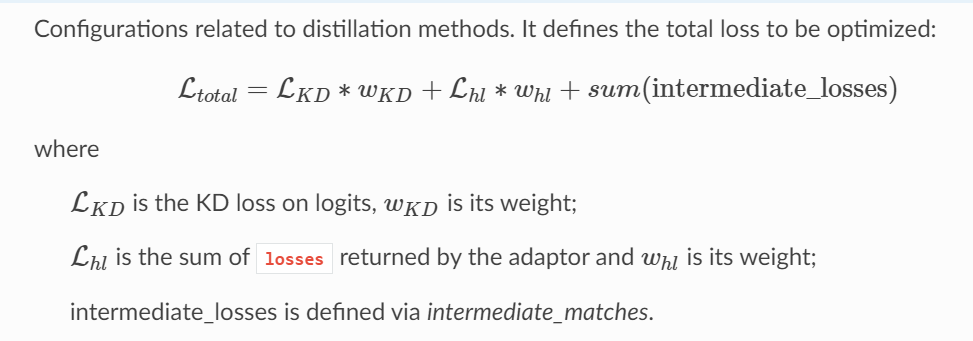

In [6]:
from IPython.display import Image

Image("./img/img.png")

In [7]:



# TODO num_steps should be passed to distiller.train()
train_config = TrainingConfig(device=device, ckpt_steps=50, output_dir="../../distillation/")
distill_config = DistillationConfig(
    temperature=8,
    hard_label_weight=0,
    kd_loss_type='ce',
    probability_shift=False,
    intermediate_matches=[
        {'layer_T': 0, 'layer_S': 0, 'feature': 'hidden', 'loss': 'hidden_mse', 'weight': 1},
        {'layer_T': 2, 'layer_S': 2, 'feature': 'hidden', 'loss': 'hidden_mse', 'weight': 1},
        {'layer_T': 4, 'layer_S': 4, 'feature': 'hidden', 'loss': 'hidden_mse', 'weight': 1},

        {'layer_T': 0, 'layer_S': 0, 'feature': 'attention', 'loss': 'hidden_mse', 'weight': 1},
        {'layer_T': 2, 'layer_S': 2, 'feature': 'attention', 'loss': 'hidden_mse', 'weight': 1},
        {'layer_T': 4, 'layer_S': 4, 'feature': 'attention', 'loss': 'hidden_mse', 'weight': 1}
    ]
)

print("train_config:")
print(train_config)

print("distill_config:")
print(distill_config)

train_config:
gradient_accumulation_steps : 1
ckpt_frequency : 1
ckpt_epoch_frequency : 1
ckpt_steps : 50
log_dir : None
output_dir : ../../distillation/
device : cuda:0
fp16 : False
fp16_opt_level : O1
data_parallel : False
local_rank : -1

distill_config:
temperature : 8
temperature_scheduler : None
hard_label_weight : 0
hard_label_weight_scheduler : None
kd_loss_type : ce
kd_loss_weight : 1
kd_loss_weight_scheduler : None
probability_shift : False
intermediate_matches : [
IntermediateMatch: layer_T : 0, layer_S : 0, feature : hidden, weight : 1, loss : hidden_mse, proj : None, 
IntermediateMatch: layer_T : 2, layer_S : 2, feature : hidden, weight : 1, loss : hidden_mse, proj : None, 
IntermediateMatch: layer_T : 4, layer_S : 4, feature : hidden, weight : 1, loss : hidden_mse, proj : None, 
IntermediateMatch: layer_T : 0, layer_S : 0, feature : attention, weight : 1, loss : hidden_mse, proj : None, 
IntermediateMatch: layer_T : 2, layer_S : 2, feature : attention, weight : 1, loss : 

In [14]:
def simple_adaptor(batch, model_outputs):
    # The second element of model_outputs is the logits before softmax
    # The third element of model_outputs is hidden states
    return {'logits': model_outputs[2],
            'hidden': model_outputs[3].hidden_states,
            'attention': model_outputs[3].attentions,
            'inputs_mask': batch[2]}


distiller = GeneralDistiller(
    train_config=train_config, distill_config=distill_config,
    model_T=teacher_model, model_S=student_model,
    adaptor_T=simple_adaptor, adaptor_S=simple_adaptor)

scheduler_class = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, min_lr=1e-7, patience=5, verbose=True,
                                    threshold=0.0001, eps=1e-08)

scheduler_args = {
    'mode': 'max', "factor": 0.5, "min_lr": 1e-7, "patience": 5, "verbose": True,
    'threshold': 0.0001, 'eps': 1e-08
}

# Start distilling
with distiller:
    distiller.train(optimizer, train_loader, num_steps=5000,
                    scheduler_class=ReduceLROnPlateau, scheduler_args=scheduler_args, callback=callback_fun)

KeyboardInterrupt: 